# Madrid Weather Prediction

Deep Learning Adventures: meetup 2020 SEP 04

Purpose: Build a Regression model to predict air temperature

For other approaches to this same challenge, check out these solutions shared by my friends and colleagues:
    
Dmitri Levonian: https://github.com/dlevonian/madrid-weather/blob/master/madrid_temperature_1.ipynb

George Zoto: https://github.com/georgezoto/Coding-in-TensorFlow/tree/master/Time-Series-Prediction

David Patton: https://github.com/dcpatton/TimeSeries/blob/master/madrid_wx.ipynb

## Goal:

Build a model to predict mean daily temperature in Madrid at Barajas Airport.

Generally, a machine learning model consists of four components: a dataset, a model specification, a loss definition, and an optimizer algorithm. 

Here we consider:

#### Dataset:
https://www.kaggle.com/juliansimon/weather_madrid_lemd_1997_2015.csv

19 years worth of weather measurements, ranging from January 1997 to December 2015. Once per day, 22 features are recorded.

There is no pre-defined train/test split in this dataset. We will build our model using the first 16 years, setting aside the final three years for model evaluation.

#### Model:
This model will ignore additional features. We'll consider the mean temperature only as a univariate series.

Parametric approach with three components:
1. Linear Trend
2. Seasonality (Fourier Series)
3. AutoRegressive 

#### Loss:
MSE is a great loss metric here. Weather data won't contain impactful outliers. (If we do find excessive outliers, we will know they must be errors!) 

Also, MAE will be computed. Not for model training or selection, but for performance reporting.

#### Optimizer:
One nice aspect of least-squares linear regression: the optimization problem is convex. But in fact, since the global minimum can be obtained by a matrix computation, no optimization algorithm is necessary.


# Outline

1. Data Exploration
2. Treatment of Missing Data
3. Model Definition
4. Trend
5. Seasonality
6. AutoRegression 
7. Performance Measurement

#### Imports

In [256]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
from matplotlib import pylab as plt
figsize=[12,8]
plt.rcParams['figure.figsize'] = figsize
plt.rcParams['figure.dpi'] = 100
plt.rcParams['agg.path.chunksize'] = 10000
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment',None)

In [102]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression
import scipy.stats as scs

In [103]:
from scipy import linalg
from statsmodels.tsa.stattools import acf as sm_acf
from statsmodels.tsa.stattools import acovf as sm_acovf
from statsmodels.tsa.stattools import pacf as sm_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox as sm_acorr_ljungbox

#### Helper Functions for Plotting

In [395]:
def plot_series(dfs, cols_or_labels, *args, **kwargs):
    # plot one or more Series or DataFrame objects on one figure
    # default x values: DATE
    # optional kwargs {'xlabel','ylabel'}
    # pass other args/kwargs directly to plt.plot()
    if not(isinstance(dfs,list)):
        plot_series([dfs],cols_or_labels,*args,**kwargs)
    elif not(isinstance(cols_or_labels,list)):
        plot_series(dfs,[cols_or_labels],*args, **kwargs)
    else:
        if ('figsize' in kwargs):
            plt.figure(figsize=kwargs.pop('figsize'))
        else:
            plt.figure(figsize=(16,6))
        if ('xlabel' in kwargs):
            plt.xlabel(kwargs.pop('xlabel'))
        if ('ylabel' in kwargs):
            plt.ylabel(kwargs.pop('ylabel'))
        elif (len(cols_or_labels)==1):
            plt.ylabel(cols_or_labels[0])
        if (len(dfs)<len(cols_or_labels)):
            assert (len(dfs)==1)
            dfs = dfs*len(cols_or_labels)
        elif (len(dfs)>len(cols_or_labels)):
            assert (len(cols_or_labels)==1)
            cols_or_labels = cols_or_labels*len(dfs)
        for j in range(len(dfs)):
            try:
                t=dfs[j].date
                plt.xlabel('date')
            except:
                t=dfs[j].index
            if (isinstance(dfs[j],pd.DataFrame)):
                series = dfs[j][cols_or_labels[j]]
            else:
                series = pd.Series(dfs[j])
                cols_or_labels[j] = (cols_or_labels[j] if (cols_or_labels[j]) else series.name)
            plt.plot(t,series,label=cols_or_labels[j],*args,**kwargs)
        plt.legend()
        plt.grid(True)
        plt.show()

In [105]:
# Here is a useful visualization function for time series analysis:
    # ACF / PACF / QQ_Plot / Prob_Plot
    # adapted from http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax,linestyle='none',marker='o',markersize=4)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax,alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

# 1. Objective

Goal: predict daily mean temperature at Barajas airport in Madrid

We have 19 years of weather measurements.

To assess performance, we need to set aside 

# 2. Data Exploration

In [106]:
# Dataset is just one CSV file:
df_raw = pd.read_csv('data/weather_madrid_LEMD_1997_2015.csv')

In [107]:
df_raw.shape

(6812, 23)

In [108]:
df_raw.head()

,CET,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,1997-1-1,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,1008,1004,10.0,9.0,4.0,13,6,NaN,0.0,6.0,NaN,229
1,1997-1-2,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007,1003,997,10.0,9.0,4.0,26,8,47.0,0.0,5.0,Rain,143
2,1997-1-3,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005,999,996,10.0,10.0,7.0,27,19,NaN,0.0,6.0,Rain-Snow,256
3,1997-1-4,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012,1010,1005,10.0,10.0,10.0,27,19,40.0,0.0,2.0,NaN,284
4,1997-1-5,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012,1008,1005,10.0,5.0,1.0,14,6,NaN,0.0,7.0,Snow,2


In [109]:
rename_dict =  {'CET'                           :'date',
                'Max TemperatureC'              :'temperature_max',
                'Mean TemperatureC'             :'temperature',
                'Min TemperatureC'              :'temperature_min',
                'Dew PointC'                    :'dewpoint_max',
                'MeanDew PointC'                :'dewpoint',
                'Min DewpointC'                 :'dewpoint_min',
                'Max Humidity'                  :'humidity_max',
                ' Mean Humidity'                :'humidity',
                ' Min Humidity'                 :'humidity_min',
                ' Max Sea Level PressurehPa'    :'pressure_max',
                ' Mean Sea Level PressurehPa'   :'pressure',
                ' Min Sea Level PressurehPa'    :'pressure_min',
                ' Max VisibilityKm'             :'visibility_max',
                ' Mean VisibilityKm'            :'visibility',
                ' Min VisibilitykM'             :'visibility_min',
                ' Max Wind SpeedKm/h'           :'windspeed_max',
                ' Mean Wind SpeedKm/h'          :'windspeed',
                ' Max Gust SpeedKm/h'           :'gustspeed',      
                'Precipitationmm'               :'precipitation',
                ' CloudCover'                   :'cloudcover',
                ' Events'                       :'events',
                'WindDirDegrees'                :'winddirection',
                }
df_raw.rename(columns=rename_dict, inplace=True)

In [110]:
print((df_raw.date[0],type(df_raw.date[0])))
# Dates are strings. We should convert them to a quantitative date-aware type:

df_raw.date = pd.to_datetime(df_raw.date)
print((df_raw.date[0],type(df_raw.date[0])))

('1997-1-1', <class 'str'>)
(Timestamp('1997-01-01 00:00:00'), <class 'pandas._libs.tslibs.timestamps.Timestamp'>)


In [111]:
# Before proceeding further, remove the test set so it won't affect our exploration or model design at all:
(df,test_df) = (df_raw[df_raw.date.dt.year<2013],df_raw[df_raw.date.dt.year>=2013])

In [112]:
print((len(df),len(test_df)))

(5717, 1095)


In [113]:
df.describe()

,temperature_max,temperature,temperature_min,dewpoint_max,dewpoint,dewpoint_min,humidity_max,humidity,humidity_min,pressure_max,pressure,pressure_min,visibility_max,visibility,visibility_min,windspeed_max,windspeed,gustspeed,precipitation,cloudcover,winddirection
count,5715.000000,5714.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,5717.000000,5717.000000,5717.000000,4777.000000,4777.000000,4777.000000,5717.000000,5717.000000,2682.000000,5717.000000,4630.000000,5717.000000
mean,20.875941,14.519776,8.587402,8.030796,4.902012,1.415923,81.137533,58.456868,36.221347,1020.398461,1018.003848,1015.529823,11.010467,9.919824,8.504919,21.658037,9.006297,43.663311,0.020388,3.239525,195.519853
std,8.841317,7.565159,6.832758,4.783309,4.694278,4.958462,17.396003,19.629104,19.221618,6.068196,6.394319,6.801470,4.675784,3.066143,3.895358,9.784401,5.081384,12.337341,0.507565,1.792508,120.985340
min,0.000000,-3.000000,-10.000000,-12.000000,-15.000000,-22.000000,16.000000,15.000000,4.000000,996.000000,990.000000,965.000000,1.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,-1.000000
25%,13.000000,8.000000,3.000000,5.000000,2.000000,-2.000000,68.000000,42.000000,20.000000,1017.000000,1014.000000,1012.000000,10.000000,10.000000,7.000000,13.000000,5.000000,35.000000,0.000000,2.000000,60.000000
50%,20.000000,14.000000,9.000000,8.000000,5.000000,2.000000,87.000000,59.000000,33.000000,1020.000000,1018.000000,1016.000000,10.000000,10.000000,10.000000,21.000000,8.000000,42.000000,0.000000,3.000000,223.000000
75%,29.000000,21.000000,14.000000,12.000000,8.000000,5.000000,94.000000,75.000000,49.000000,1024.000000,1022.000000,1020.000000,10.000000,10.000000,10.000000,27.000000,11.000000,52.000000,0.000000,5.000000,299.000000
max,41.000000,32.000000,28.000000,20.000000,16.000000,14.000000,100.000000,100.000000,100.000000,1041.000000,1040.000000,1038.000000,31.000000,31.000000,31.000000,182.000000,39.000000,103.000000,32.000000,8.000000,360.000000


## Missing Data

In [114]:
DR = pd.date_range(df.date.min(),df.date.max())
DR = pd.Series(DR,index=DR).rename('date')

In [115]:
print(len(DR) - len(df))
# there are 127 days completely absent from this dataset


print(len(df) - int(df.describe().loc['count','temperature']))
print(df.temperature.isnull().sum())
# also 3 other days are included in the df but contain no temperature measurement

127
3
3


In [116]:
# Let's peek at the test set to check whether it has the same problem:
test_DR = pd.date_range(test_df.date.min(),test_df.date.max())

print(len(test_DR) - len(test_df))
print(len(test_df) - int(test_df.describe().loc['count','temperature']))


0
0


No missing temperature data in test set

Back to exploring missing data in df:

Let's merge df into DR so that our index contains all dates

In [117]:
df = (pd.DataFrame(DR)).merge(df,how='left').set_index(DR)
# Insert the missing dates, filling the extra rows with NaN values everywhere

In [118]:
print(df.temperature.isnull().sum())

130


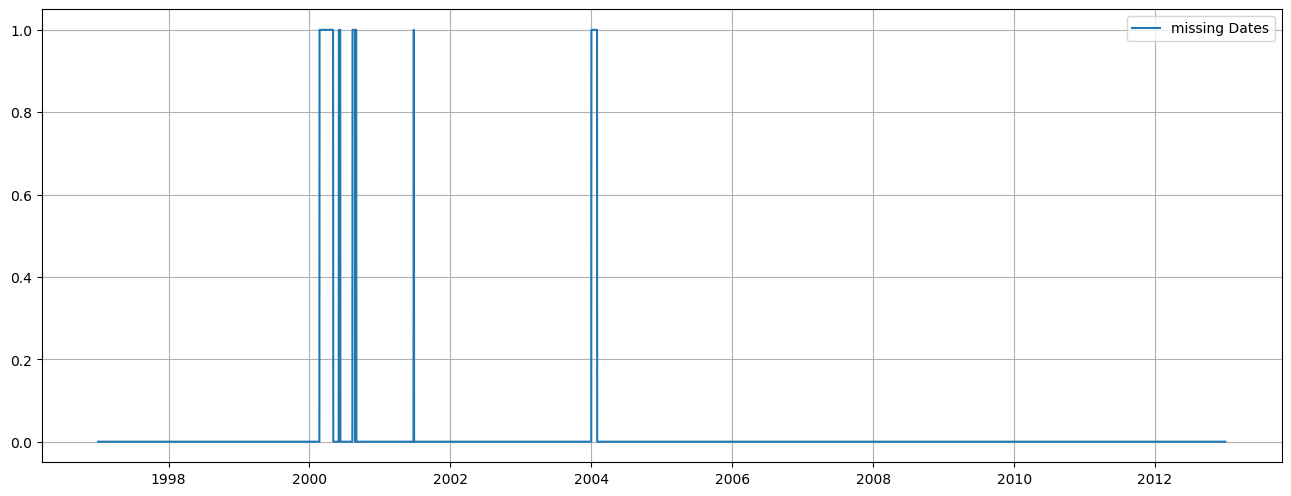

In [119]:
missingDates = (df.temperature.isnull()).rename('missing Dates')
plot_series(missingDates,None)

In [120]:
print(missingDates.index[missingDates].min())
print(missingDates.index[missingDates].max())
# Missing dates all occur in a four year stretch from 2000 to 2004. Data are contiguous beginning 2004 February 01

2000-02-23 00:00:00
2004-01-31 00:00:00


Zoom in on this four-year period:

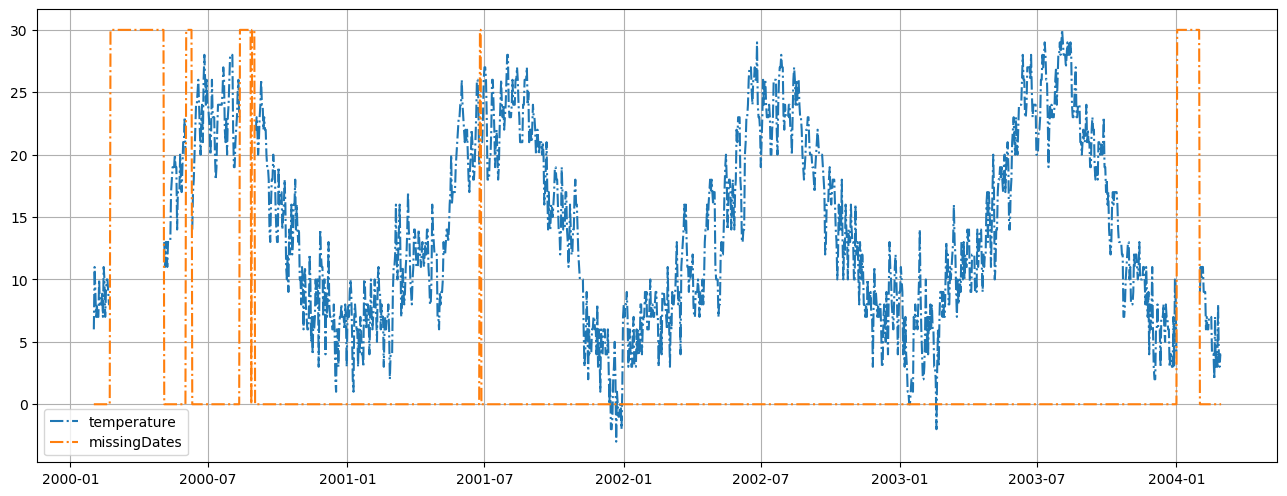

In [121]:
timeBounds = [pd.Timestamp('2000-02-01'),pd.Timestamp('2004-03-01')]
dateSelection = (df.date >= timeBounds[0]) & (df.date < timeBounds[1])
plot_series([df.temperature[dateSelection],df.temperature[dateSelection].isnull()*30],['temperature','missingDates'],'-.')
#plot_series([df[roughPatch_orig],dfFull[roughPatch_full].temperature.isnull()*30],['temperature',None],'-.')

In [122]:
# Longest gap in temperature data is from Feb 22 to May 4, 2000:
df.temperature[(df.date.dt.year==2000) & (~df.temperature.isnull())].iloc[50:55]

date
2000-02-20     9.0
2000-02-21     8.0
2000-02-22     8.0
2000-05-04    13.0
2000-05-05    11.0
Name: temperature, dtype: float64

Missing data are especially important in time series, since we are often interested in building models that explicitly exploit relationships among successive observations.

What to do about the missing data?

Options:

1. Discard.

Discarding nulls is generally more difficult in time series than in non-sequential datasets. Many effective models tend to exploit sequential interdependence (e.g. ARIMA), so one has to be careful about how the surviving data are stitched together.

 a. In our case, however, all the missing data occur in a small portion of the overall time sequence. So we can build a model using data from Feb 2004 onward without having to worry about missing data at all. Pro: This is the easiest approach. Con: smaller dataset may be insufficient to learn signal, could overfit to noise.

 b. Discard fewer points. Eliminate the ones close to missing data, but retain some early contiguous stretches. Pro: More data. Con: More difficult data wrangling.

2. Imputation

 In some problems it may be necessary to impute missing data.
 
 For instance, if missing data were distributed all over the dataset temporally, but without long stretches of missing dates. We could estimate the missing values from a model based on some combination of prior knowledge and nearby measurements.
 
 Various approaches are implemented in this R package: https://cran.r-project.org/web/packages/imputeTS/imputeTS.pdf.   Is there an equivalent library for Python?
 
 Note: Naive imputation could produce undesirable artifacts. For instance, a straight linear interpolation might fill the months of March and April 2000 with a monotonically increasing line. Even if such an imputation correctly represents the underlying signal, an autoregressive model could then overfit to that behavior if there are too many straight line segments in the training data. One could then try to combat this by adding noise.
 
 

For simplicity, we'll choose approach 1a for the autoregressive model.

Reasoning: Temperature data are fairly consistent and predictable. As long as we choose a sufficiently parsimonious model, we can learn the signal in the temperature measurements without needing too much data.

Regardless, it would be interesting to compare performance of this approach vs. other approaches to the missing data problem. That is an exercise left for the reader :)

In [157]:
df1a = df[df.date>missingDates.index[missingDates].max()]

In [159]:
df1a.head()

,date,temperature_max,temperature,temperature_min,dewpoint_max,dewpoint,dewpoint_min,humidity_max,humidity,humidity_min,pressure_max,pressure,pressure_min,visibility_max,visibility,visibility_min,windspeed_max,windspeed,gustspeed,precipitation,cloudcover,events,winddirection
date,,,,,,,,,,,,,,,,,,,,,,,
2004-02-01,2004-02-01,12.0,9.0,7.0,9.0,8.0,6.0,100.0,92.0,82.0,1031.0,1030.0,1028.0,10.0,5.0,0.0,11.0,6.0,NaN,0.0,7.0,Fog,347.0
2004-02-02,2004-02-02,15.0,11.0,7.0,9.0,7.0,6.0,93.0,85.0,63.0,1033.0,1031.0,1030.0,10.0,10.0,8.0,10.0,5.0,NaN,0.0,5.0,NaN,353.0
2004-02-03,2004-02-03,17.0,10.0,3.0,8.0,5.0,2.0,100.0,79.0,48.0,1035.0,1033.0,1032.0,10.0,9.0,8.0,10.0,3.0,NaN,0.0,0.0,Fog,351.0
2004-02-04,2004-02-04,19.0,11.0,3.0,8.0,6.0,2.0,100.0,78.0,46.0,1037.0,1035.0,1034.0,9.0,9.0,9.0,10.0,3.0,23.0,0.0,0.0,NaN,359.0
2004-02-05,2004-02-05,19.0,11.0,3.0,8.0,5.0,2.0,100.0,76.0,40.0,1036.0,1035.0,1033.0,10.0,9.0,9.0,6.0,3.0,NaN,0.0,0.0,NaN,359.0


Note: the trend and seasonality models will be just as easy to implement with a full training set. So we'll use df for those fits, df1a for the AR model.

## Value Distribution within Discretization

In [123]:
# An interesting phenomenon is apparent in the mean temperature data:

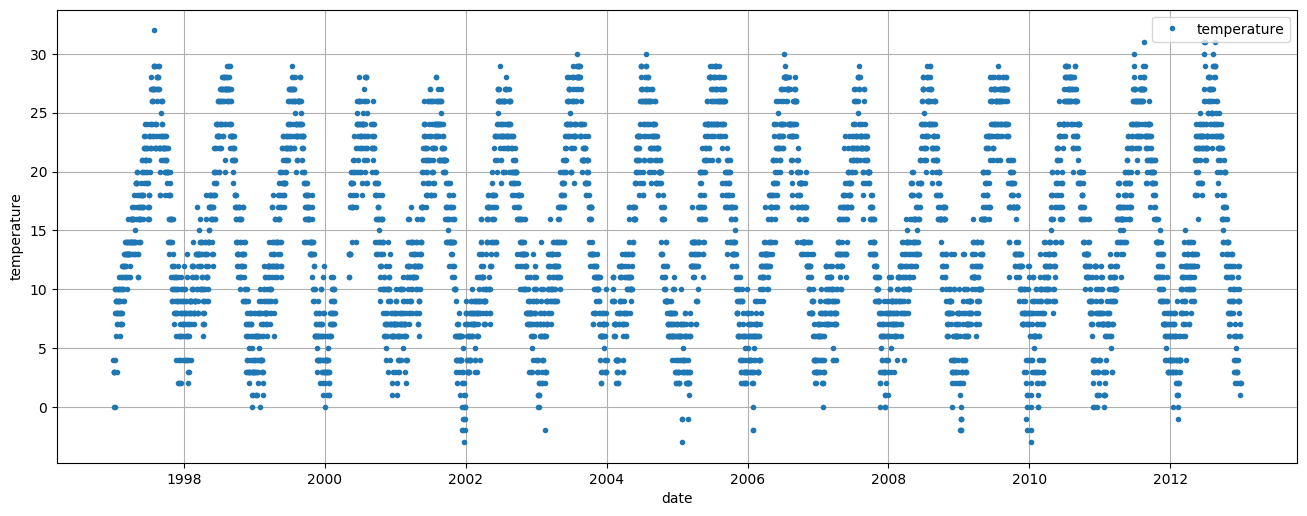

In [124]:
plot_series(df,'temperature','.')

Temperature measurements are integers so they do not fill the space vertically.

But look across the grid lines. You will also notice there are far fewer points where temperature=15C than where temperature=14C or 16C. The same thing happens at 25C and at 5C. Weird. 

Text(0, 0.5, 'Value Count')

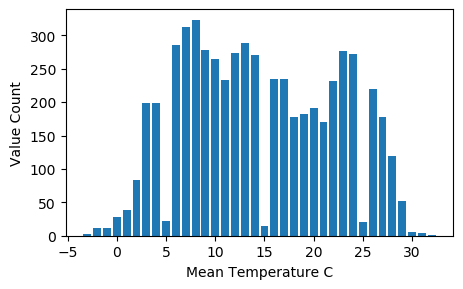

In [125]:
VC = df.temperature.value_counts().sort_index()
plt.figure(figsize=(5,3))
plt.bar(VC.index,VC)
plt.xlabel('Mean Temperature C')
plt.ylabel('Value Count')

Highlight this using color:

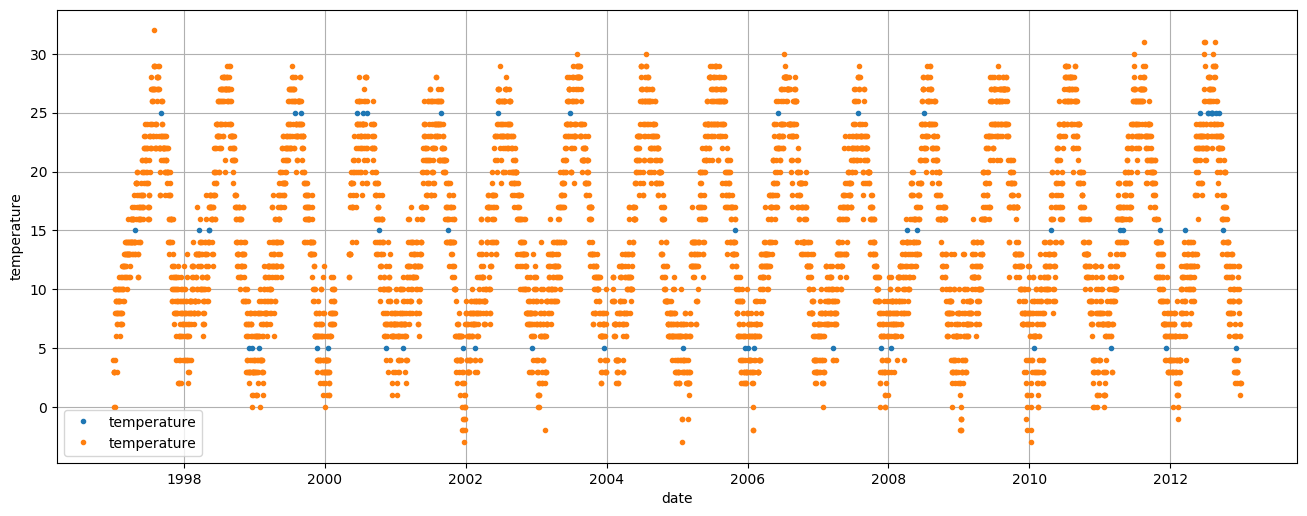

In [126]:
odd5 = ((~(df.temperature%5).astype(bool)) & ((df.temperature%2).astype(bool)))
plot_series([df.loc[odd5],df.loc[~odd5]],'temperature','.')

The distribution of the blue points appears independent of time, so it's not due to a change in the measurement process.

Interestingly, this phenomenon does not occur in temperature_max or temperature_min. In those series, the values ending in '5' occur at frequencies that are consistent with surrounding values

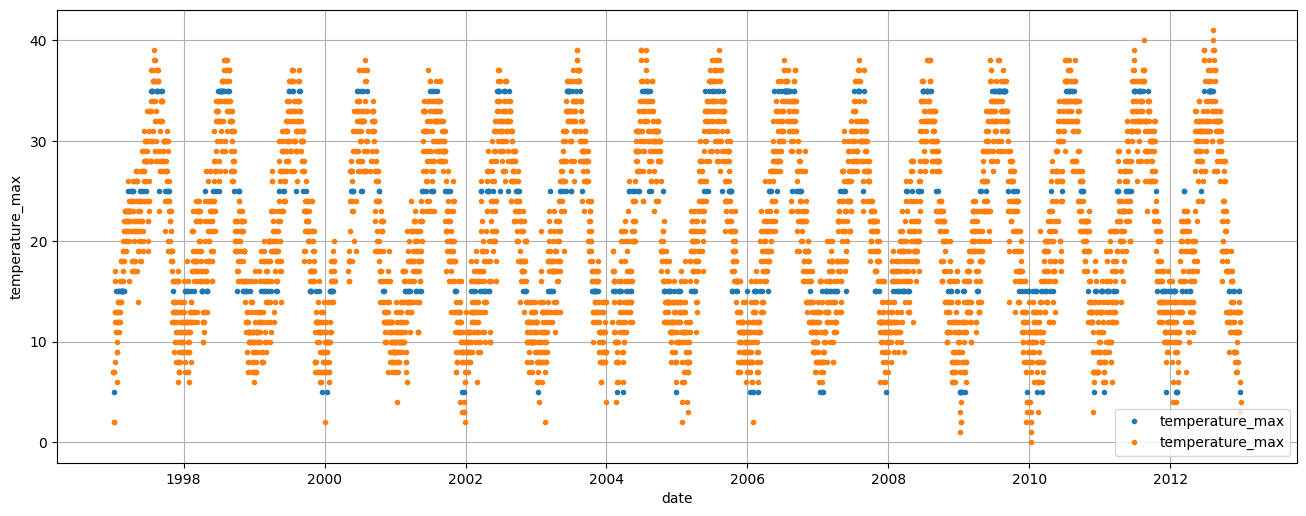

In [127]:
odd5 = ((~(df.temperature_max%5).astype(bool)) & ((df.temperature_max%2).astype(bool)))
plot_series([df.loc[odd5],df.loc[~odd5]],'temperature_max','.')

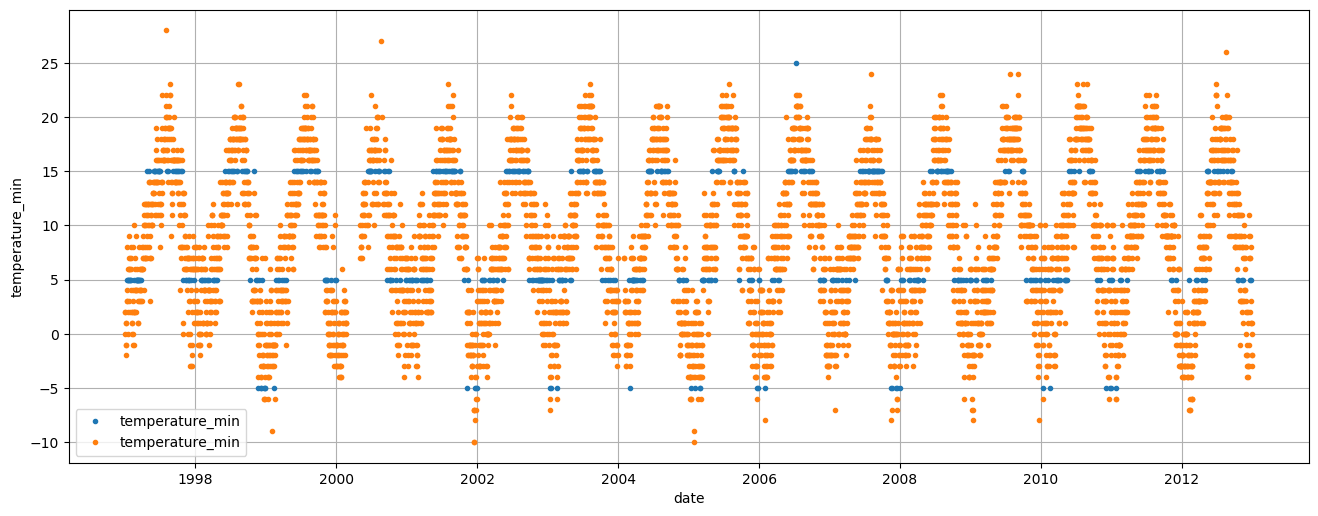

In [128]:
odd5 = ((~(df.temperature_min%5).astype(bool)) & ((df.temperature_min%2).astype(bool)))
plot_series([df.loc[odd5],df.loc[~odd5]],'temperature_min','.')

In [130]:
temperatureColumns = ['temperature_max','temperature','temperature_min']
valCounts = df[temperatureColumns].apply(lambda PS: PS.value_counts(),axis=0).fillna(0)

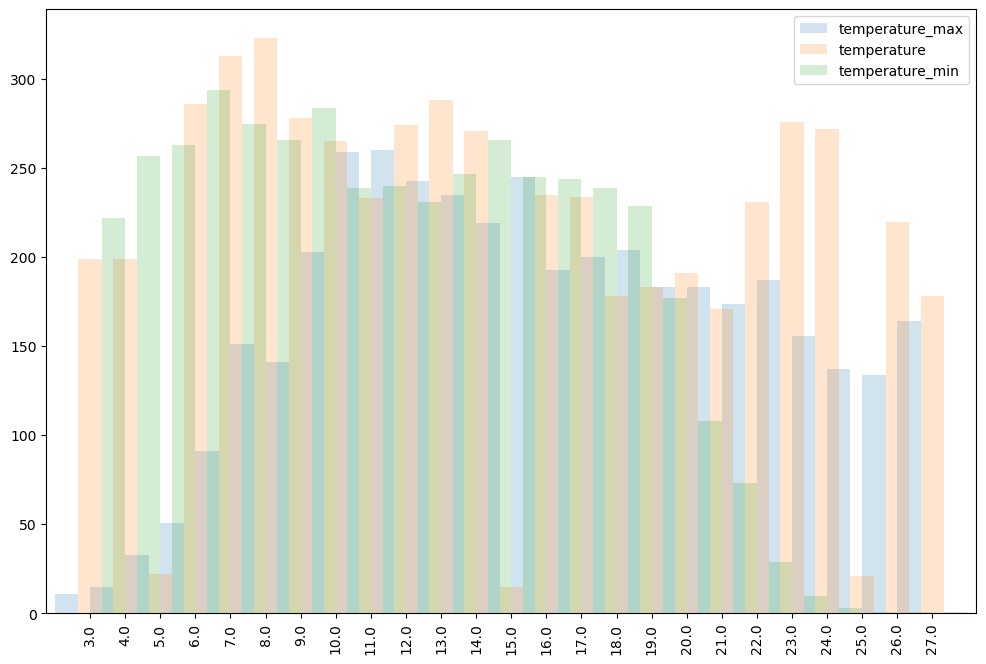

In [154]:
valCounts[(valCounts.index<28) & (valCounts.index>2)].plot.bar(width=2,alpha=0.2)

In [ ]:
# The orange bars are abnormally low at odd multiples of 5, but the blue and green ones aren't.
# Not the easiest visualization to interpret. Perhaps an alternate view of the same histogram is clearer:

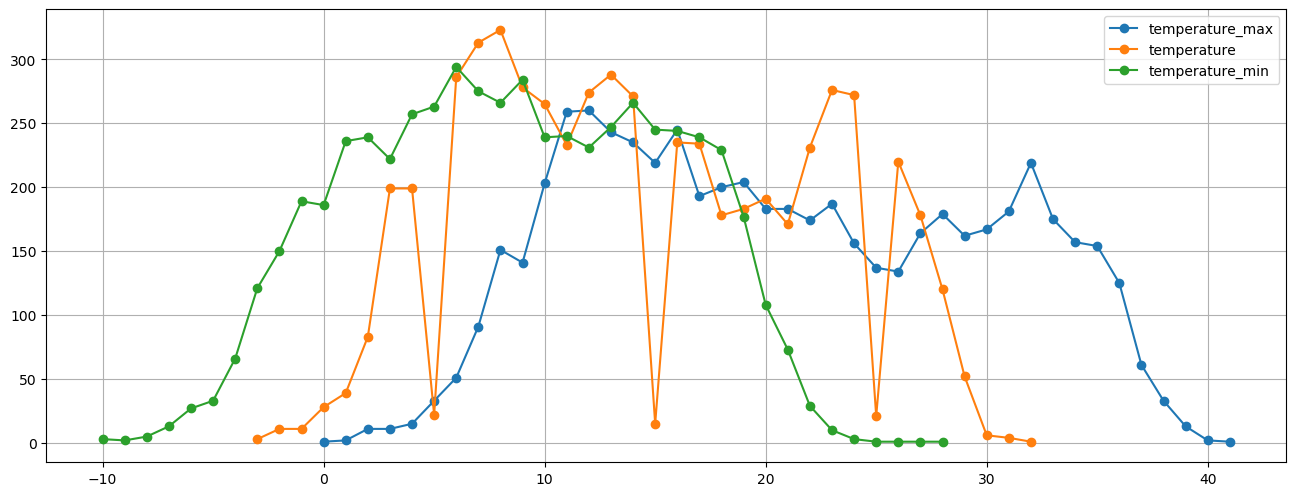

In [156]:
plot_series([df[col].value_counts().sort_index() for col in temperatureColumns],None,'-o')

Why might temperature behave thusly while temperature_max and temperature_min don't?

One explanation: perhaps mean temperature is computed directly from the others, and something is being rounded in a way that makes the odd multiples of 5 less likely. We won't investigate this further.

## Distribution of Differenced Temperature Series

We include autoregression in our model because we believe there is a relationship between temperature measurements on nearby days, even after trend and seasonality have been removed from the dataset. 

Let's explore the distribution of temperature differences between two days in our dataset, as a function of lag, the number of days between the two measurements.

Expected Properties:
    
1. If the dataset has no trend, the distribution will be symmetric about zero, regardless of lag. With trend, we would see a positive or negative bias. 
2. If the dataset has seasonality, the distribution will be narrower when lag is close to the underlying period $P$.
3. If there are relationships between nearby dates over and above seasonality (e.g. an AR process), the distribution at a small lag $k$ will look very different than the distribution at lag $P+k$

Let's look at a few such distributions:

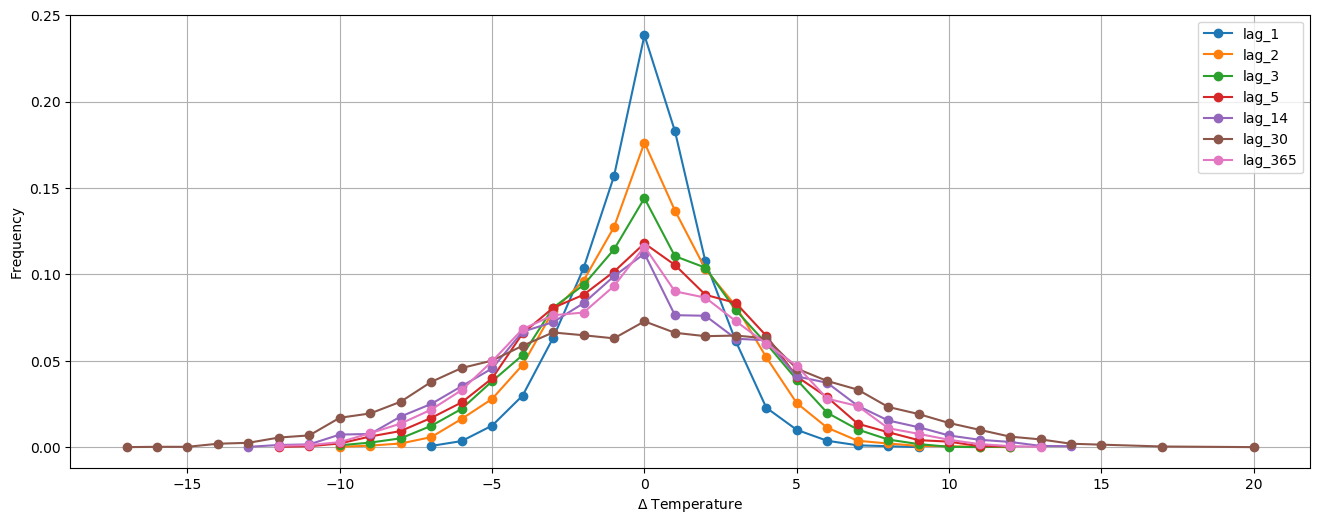

In [167]:
lags = [1,2,3,5,14,30,365]
diff_ps = [df.temperature.diff(k).rename('offset_%d'%k) for k in lags]
valueCount_ps = [df.temperature.diff(k).value_counts() for k in lags]
diffsHistograms_List = [vcps.sort_index()/vcps.sum() for vcps in valueCount_ps]
names = ['lag_%d'%k for k in lags]
plot_series(diffsHistograms_List,names,'-o',xlabel='$\Delta$ Temperature',ylabel='Frequency')


TREND: Not surprisingly, distributions are quite symmetric. If there is a trend, it's small compared to other sources of variation.

SEASONALITY: We expect the period of seasonality to be one year, which corresponds to 365 days. Behavior at lag 365 should be indicative of how much of the overall variance is explained by seasonality alone.

AUTO-REGRESSION: The distribution is much tighter at lag 1 than lag 365, indicating that a seasonal ARIMA model is a good bet for this process. As lag increases from 1, distribution width increases. At lag 5, we're already quite close to the distribution at lag 365. So seasonal expectation is about as good a predictor of temperature 5 days out as today's measurement. This doesn't change too much all the way out to lag 14, but at lag 30, the increased spread is very evident, showing the effect of seasonality.

In [ ]:
# Visualize std as a function of lag:

No handles with labels found to put in legend.


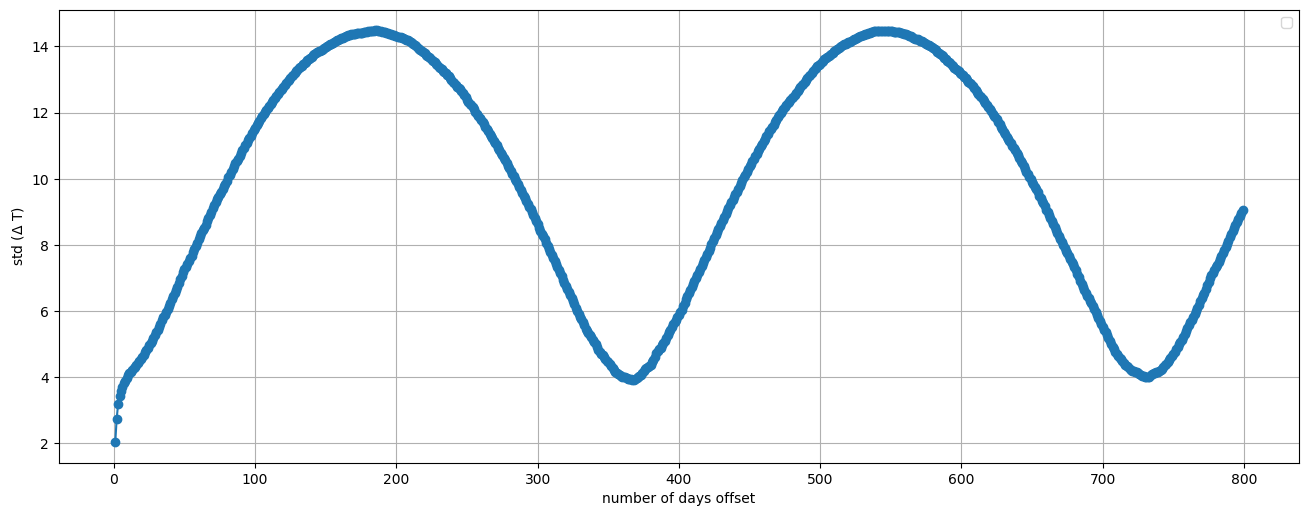

In [171]:
lags = range(1,800)
std_list = [df.temperature.diff(k).std() for k in lags]
plot_series(pd.Series(std_list,index=list(lags)),None,
                 '-o',xlabel='number of days offset',ylabel='std ($\Delta$ T)')

In [173]:
# Zoom in on small lags:

No handles with labels found to put in legend.


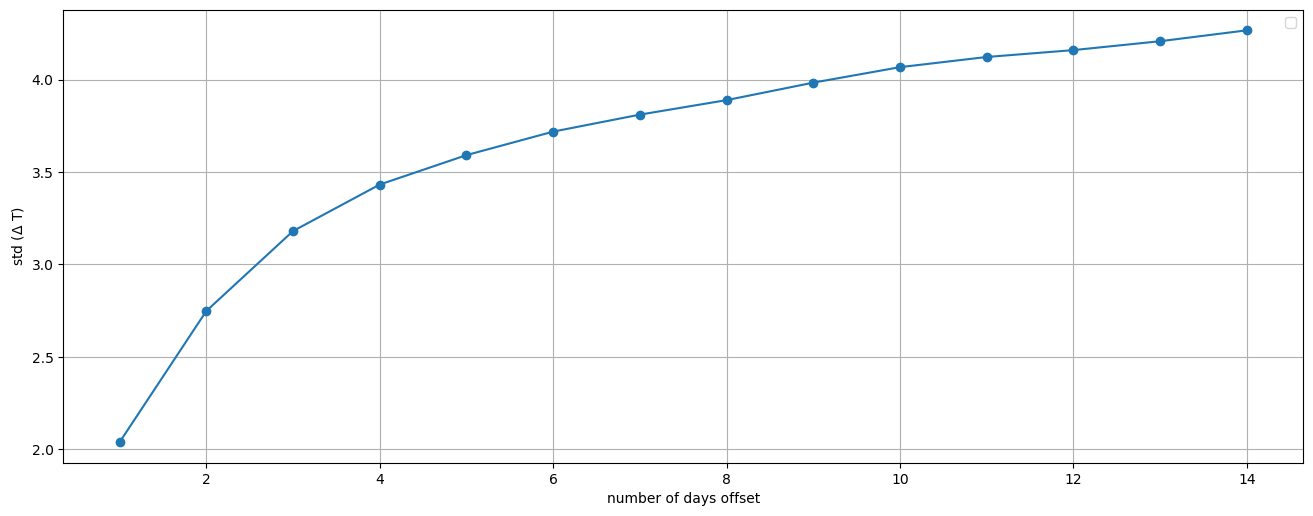

In [172]:
lags = range(1,15)
std_list = [df.temperature.diff(k).std() for k in lags]
plot_series(pd.Series(std_list,index=list(lags)),None,
                 '-o',xlabel='number of days offset',ylabel='std ($\Delta$ T)')

In [174]:
# Zoom in on 365:

No handles with labels found to put in legend.


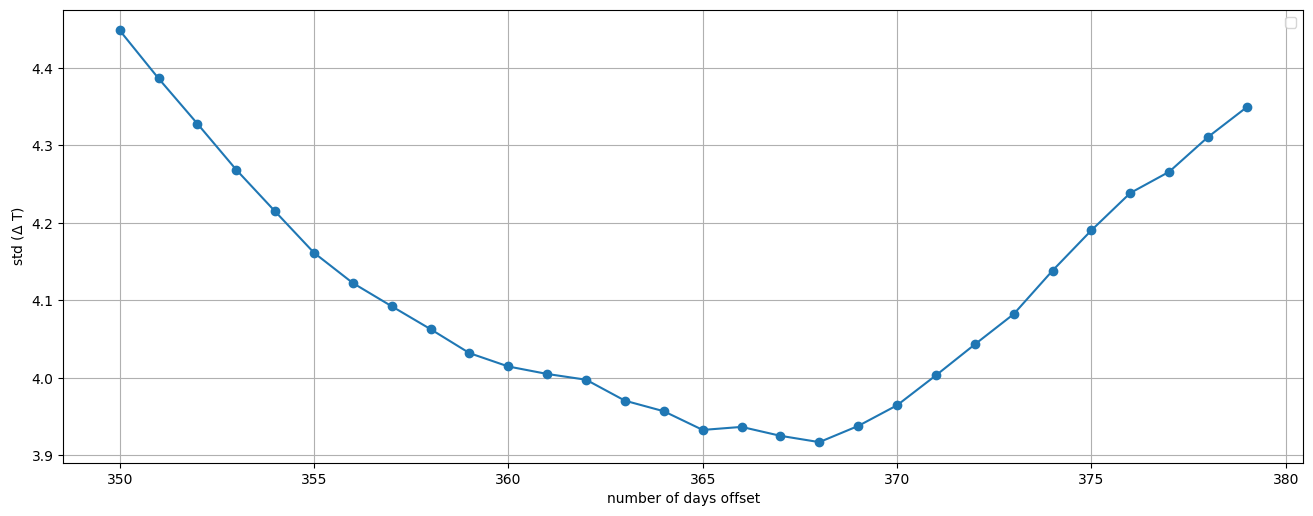

In [175]:
lags = range(350,380)
std_list = [df.temperature.diff(k).std() for k in lags]
plot_series(pd.Series(std_list,index=list(lags)),None,
                 '-o',xlabel='number of days offset',ylabel='std ($\Delta$ T)')

Local minimum std occurs at lag 368, not 365, due to noise.

No handles with labels found to put in legend.


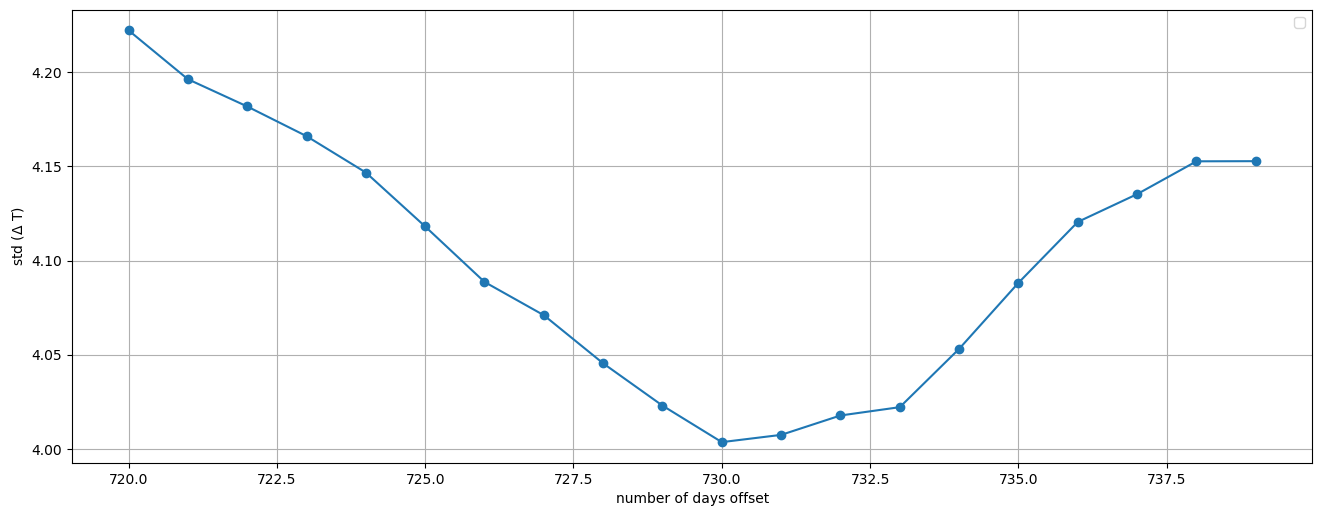

In [176]:
lags = range(720,740)
std_list = [df.temperature.diff(k).std() for k in lags]
plot_series(pd.Series(std_list,index=list(lags)),None,
                 '-o',xlabel='number of days offset',ylabel='std ($\Delta$ T)')

Two-year local minimum std occurs at lag 730

# Baseline model

Best single predictor is lag 1. Simply echoing the preceding day's measurement should be consider our baseline model. Already we can achieve the following on the training set.

In [181]:
k=1
print('RMSE = %0.3f' % (df1a.temperature.diff(k).std()))
print('MAE = %0.3f' % (df1a.temperature.diff(k).abs().mean()))

RMSE = 2.020
MAE = 1.507


Pretty good baseline. Can we do any better using trend, seasonality, and ARIMA?

# Full Model

## Approach

Fit Trend

Fit Seasonality based on known period

Fit a predictive model to the residuals

In [ ]:
dates = pd.date_range(df_raw.date.min(),df_raw.date.max())
dates = pd.Series(dates,index=dates)

# Trend

Is there a linear trend in this dataset?

If so, it's obviously dwarfed by seasonality. But let's look.

Generally we want to compare models using a validation set: Let's use the last three years of df (2010-2012) for validation

In [188]:
train_df, val_df = (df[df.date.dt.year<2010], df[df.date.dt.year>=2010])

Compare:

1. No trend
2. Linear trend, computed from mean data grouped by years
    

### 1. No trend

With no trend, best OLS fit is the dataset mean.

To avoid sampling bias due to seasonal imbalance in missing data, let's downselect only the measurements from years that don't contain any missing dates. This will throw out years 2000, 2001, and 2004.

In [186]:
completeYears = ~df.temperature.isnull().groupby(df.date.dt.year).any()
yearlyMeanTemperature = (df.groupby(df.date.dt.year)['temperature'].sum()/ \
        df.groupby(df.date.dt.year)['temperature'].count()).loc[completeYears]

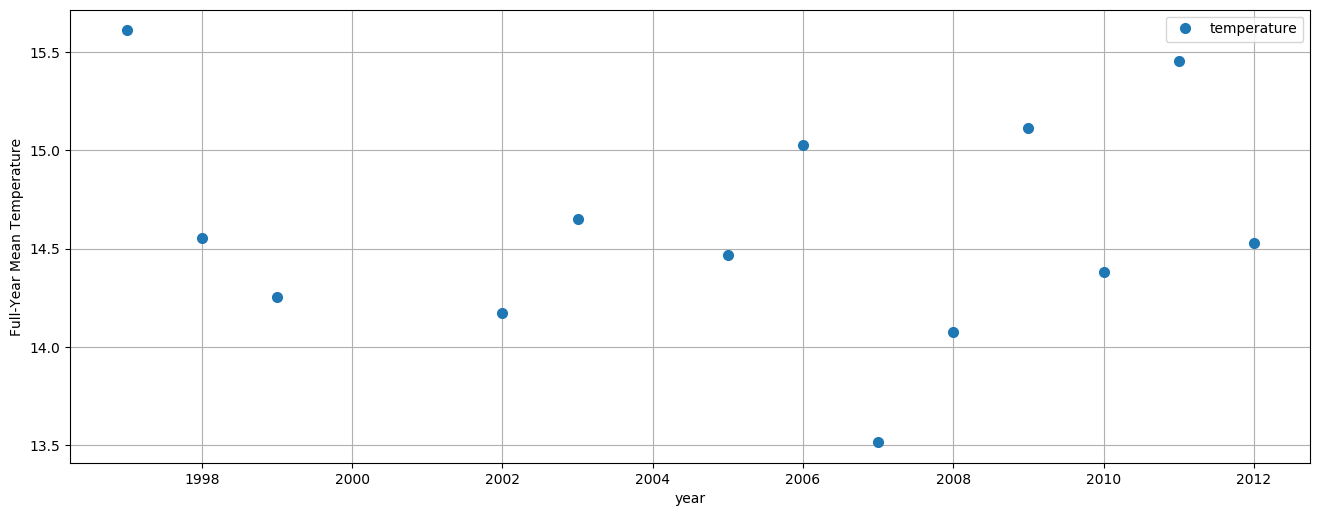

In [187]:
plot_series(yearlyMeanTemperature,None,'.',markersize=14,xlabel='year',ylabel='Full-Year Mean Temperature')

In [194]:
year_is_val = yearlyMeanTemperature.index>=2010
YMT_train,YMT_val = (yearlyMeanTemperature[~year_is_val],yearlyMeanTemperature[year_is_val])

In [197]:
YMT_train

date
1997    15.610959
1998    14.556164
1999    14.252055
2002    14.169863
2003    14.652055
2005    14.465753
2006    15.027397
2007    13.515068
2008    14.073770
2009    15.115068
Name: temperature, dtype: float64

In [199]:
noTrendModel = YMT_train.mean() # constant
YMT_train.mean()

14.543815405344711

In [208]:
# Remove mean from temperature data and from year index.
# This ensures linear model must pass thru origin, removing the intercept as a degree of freedom
xbar = sum(YMT_train.index)/len(YMT_train.index)
ybar = YMT_train.mean()
(x,y) = (YMT_train.index-xbar,YMT_train-ybar)

In [214]:
# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html

In [213]:
sm_trendModel_goodYears = OLS(y,x)
results = sm_trendModel_goodYears.fit()
print(results.params)
print()
print(results.tvalues)
print()
print(results.t_test([1]))

x1   -0.040064
dtype: float64

x1   -0.902078
dtype: float64

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0401      0.044     -0.902      0.391      -0.141       0.060



Insufficient evidence for trend, in the complete year aggregated data.

abs(coef) < std_err, and p-value is 0.4

What if we represent each date at the correct place within the year? (Make it continuous-valued throughout the year)

Define "Day of Year" (DOY) as a decimal between 0 and 1 that represents the portion of the year up to the current date.
DOY will vary from 0 on January 1 on January 1, up to 364/365 = 0.9973 on December 31. For leap years, use 366 in the denominator.

This variable will also be helpful for determining seasonality, as we'll be assuming that the true period is one full year exactly (365.25 days on average)

In [228]:
# Date conversions:
def add_DOY(myDataFrame):
    myDataFrame['DOY'] = (myDataFrame.date.dt.dayofyear-1) / (365+myDataFrame.date.dt.is_leap_year)
    myDataFrame['Year_f'] = myDataFrame.date.dt.year + myDataFrame.DOY
    return(myDataFrame)

In [229]:
df = add_DOY(df)
df1a = add_DOY(df1a)
train_df = add_DOY(train_df)
val_df = add_DOY(val_df)
test_df = add_DOY(test_df)

C:\Users\rek\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rek\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [233]:
train_df.Year_f.head()

date
1997-01-01    1997.000000
1997-01-02    1997.002740
1997-01-03    1997.005479
1997-01-04    1997.008219
1997-01-05    1997.010959
Name: Year_f, dtype: float64

In [234]:
train_df.Year_f.tail()

date
2009-12-27    2009.986301
2009-12-28    2009.989041
2009-12-29    2009.991781
2009-12-30    2009.994521
2009-12-31    2009.997260
Name: Year_f, dtype: float64

In [235]:
missingDates =  (train_df.temperature.isnull()).rename('missing Dates')

In [236]:
xbar = train_df.Year_f[~missingDates].mean()
ybar = train_df.temperature[~missingDates].mean()
(x,y) = (train_df.Year_f[~missingDates]-xbar, train_df.temperature[~missingDates]-ybar)

In [276]:
print(ybar)

14.456258120398441


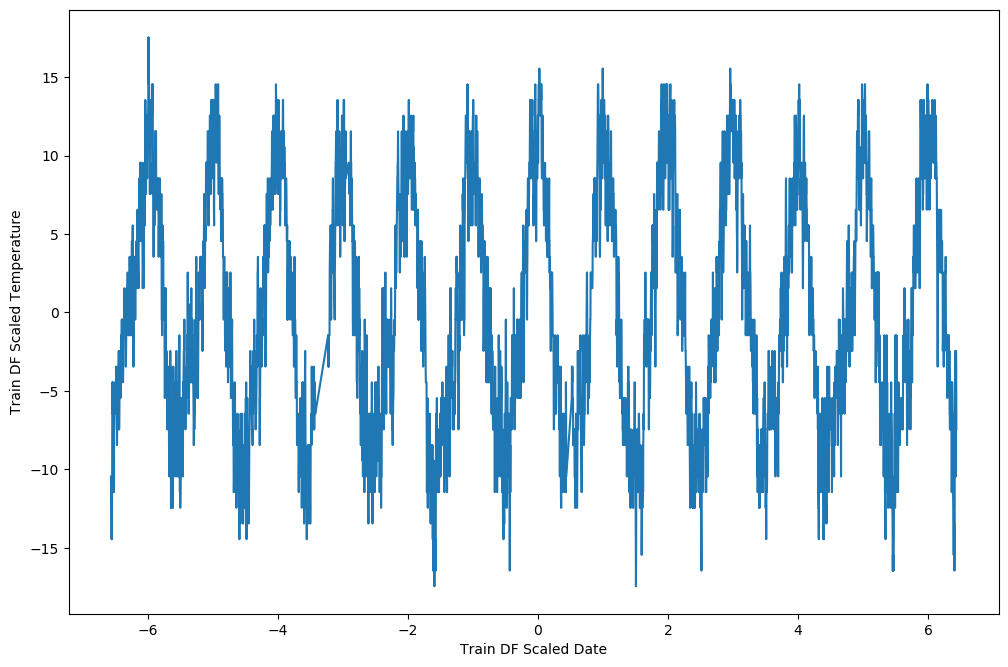

In [240]:
plt.plot(x,y)
plt.xlabel('Train DF Centered Date')
_=plt.ylabel('Train DF Centered Temperature')

In [241]:
sm_trendModel_allDates = OLS(y,x)
results = sm_trendModel_allDates.fit()
print(results.params)
print()
print(results.tvalues)
print()
print(results.t_test([1]))

Year_f    0.004706
dtype: float64

Year_f    0.161343
dtype: float64

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0047      0.029      0.161      0.872      -0.052       0.062


Again, regression coefficient is less than its standard error, and p-value is large.

We will assume zero trend in the data.

In [ ]:
# Repeat trend-line regression in sklearn:

In [ ]:
# could have done this with other packages, including sklearn

In [249]:
sk_trendModel_allDates = LinearRegression(fit_intercept=False).fit(x.to_numpy().reshape(-1, 1),y)

In [252]:
print(sk_trendModel_allDates.score(x.to_numpy().reshape(-1, 1), y))
print((sk_trendModel_allDates.coef_))

5.638157263954113e-06
[0.00470628]


We'll model with zero trend.

# Seasonality

We assume the underlying period is exactly one year.

If we were plot average temperature as a function of calendar date, using data collected over enough years to eliminate noise, we should get a result that varies very smoothly from one day to the next.  i.e. There won't be any discontinuities or sharp edges in the underlying seasonal signal.


[Fourier series](https://en.wikipedia.org/wiki/Fourier_series) work exceptionally well for modeling smooth periodic functions. Our data look very sinusoidal, so we might be able to approximate the seasonal signal using a Fourier series containing very few terms.

To avoid seasonal bias in our seasonal model, we'll discard all points from the three incomplete years 2000, 2001, and 2004

In [328]:
train_df_hasFullYear = train_df[train_df.date.dt.year.isin(YMT_train.index)]

In [367]:
len(train_df_hasFullYear)

3651

In [329]:
# Generate some Fourier basis functions:
    # freq=1 has annual frequency
    # other frequencies are integer multiples
maxFreq=10
for freq in range(1,1+maxFreq):
    train_df_hasFullYear['sin_%02d'%freq] = np.sin(2*np.pi*train_df_hasFullYear.DOY*freq)
    train_df_hasFullYear['cos_%02d'%freq] = np.cos(2*np.pi*train_df_hasFullYear.DOY*freq)
    val_df['sin_%02d'%freq] = np.sin(2*np.pi*val_df.DOY*freq)
    val_df['cos_%02d'%freq] = np.cos(2*np.pi*val_df.DOY*freq)
    test_df['sin_%02d'%freq] = np.sin(2*np.pi*test_df.DOY*freq)
    test_df['cos_%02d'%freq] = np.cos(2*np.pi*test_df.DOY*freq)

In [330]:
train_df_hasFullYear.head().iloc[:,-22:-14]

,DOY,Year_f,sin_01,cos_01,sin_02,cos_02,sin_03,cos_03
date,,,,,,,,
1997-01-01,0.000000,1997.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1997-01-02,0.002740,1997.002740,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667
1997-01-03,0.005479,1997.005479,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671
1997-01-04,0.008219,1997.008219,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023
1997-01-05,0.010959,1997.010959,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740


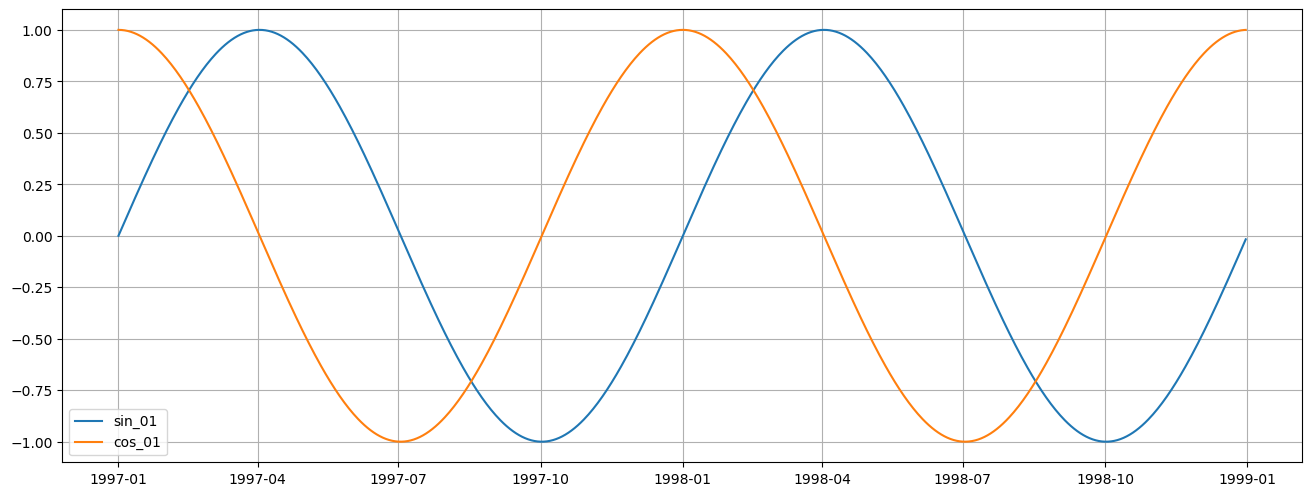

In [331]:
plot_series([train_df_hasFullYear[train_df_hasFullYear.date.dt.year<1999].sin_01,
             train_df_hasFullYear[train_df_hasFullYear.date.dt.year<1999].cos_01],None)

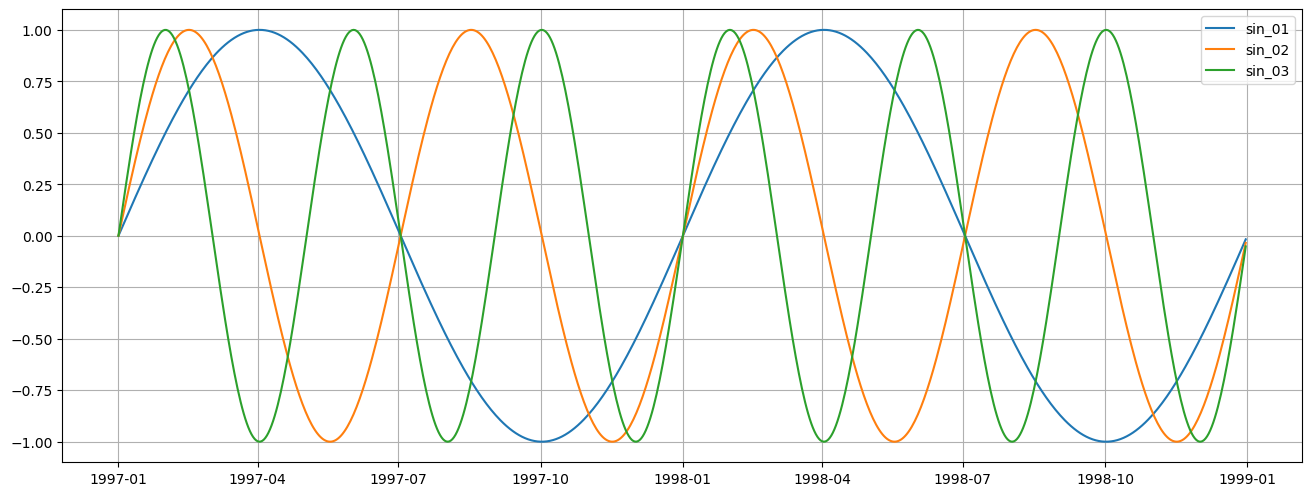

In [332]:
plot_series([train_df_hasFullYear[train_df_hasFullYear.date.dt.year<1999].sin_01,
            train_df_hasFullYear[train_df_hasFullYear.date.dt.year<1999].sin_02,
            train_df_hasFullYear[train_df_hasFullYear.date.dt.year<1999].sin_03],None)

In [342]:
# Fit 10 seasonal Fourier models, model order = 1 through 10
    # Each model considers a linear combination of the Fourier basis functions up through frequency = f
    # Number of Parameters for each model = 2*(Model Order)
# Model order allows us to tradeoff bias/variance. See where the best fit is.
sm_seasModel = [None]
seasModelResults = [None]
for modelOrder in range(1,1+maxFreq): 
    components_TL = [(('sin_%02d'%f),('cos_%02d'%f)) for f in range(1,1+modelOrder)]
    components = [component for pair in components_TL for component in pair]
    sm_seasModel.append(OLS(train_df_hasFullYear.temperature-ybar,train_df_hasFullYear[components],missing='drop'))
    seasModelResults.append(sm_seasModel[-1].fit())

In [343]:
ybar=train_df_hasFullYear.temperature.mean()
print(ybar)

14.543686661188715


In [344]:
print(seasModelResults[1].params)
print()

sin_01   -3.050912
cos_01   -9.179762
dtype: float64



In [345]:
# First-order model is a sinusoid. What are the amplitude and phase?
amplitude = np.sqrt(seasModelResults[1].params.sin_01**2+seasModelResults[1].params.cos_01**2)
phase_fraction = (np.arctan2(seasModelResults[1].params.sin_01,seasModelResults[1].params.cos_01)+np.pi)/(2*np.pi)
phase_day = phase_fraction*365
print((amplitude,phase_fraction,phase_day))
# First-order results make sense: 
# Amplitude ~= 10 C
    # => Year Mean ~= 15 C
    # => Summer Peak ~= 25 C, Winter Peak ~= 5 C
# phase_day = 19 (out of 365) 
    # Min Temperature is occurring on January 19

(9.67347395500909, 0.051067581985230634, 18.639667424609183)


In [369]:
seasModelPredictions_train = [None]
for modelOrder in range(1,1+maxFreq): 
    thisPred = ybar
    for f in range(1,1+modelOrder):
        thisPred += seasModelResults[modelOrder].params['sin_%02d'%f]*train_df_hasFullYear['sin_%02d'%f]
        thisPred += seasModelResults[modelOrder].params['cos_%02d'%f]*train_df_hasFullYear['cos_%02d'%f]
    seasModelPredictions_train.append(thisPred.rename('seasModel_%02d'%modelOrder))
seasModelResiduals_train=[None]
for modelOrder in range(1,1+maxFreq):
    seasModelResiduals_train.append(
        (train_df_hasFullYear.temperature - seasModelPredictions_train[modelOrder]).rename('residuals_%02d'%freq))

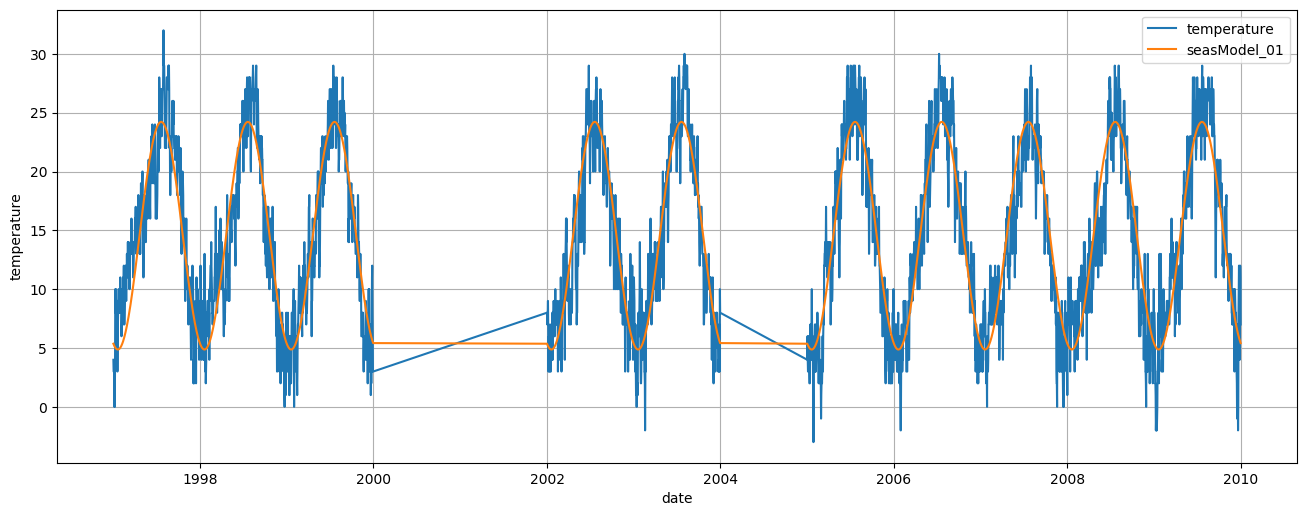

In [370]:
plot_series([train_df_hasFullYear.temperature,seasModelPredictions_train[1]],None,
                   xlabel='date',ylabel='temperature')

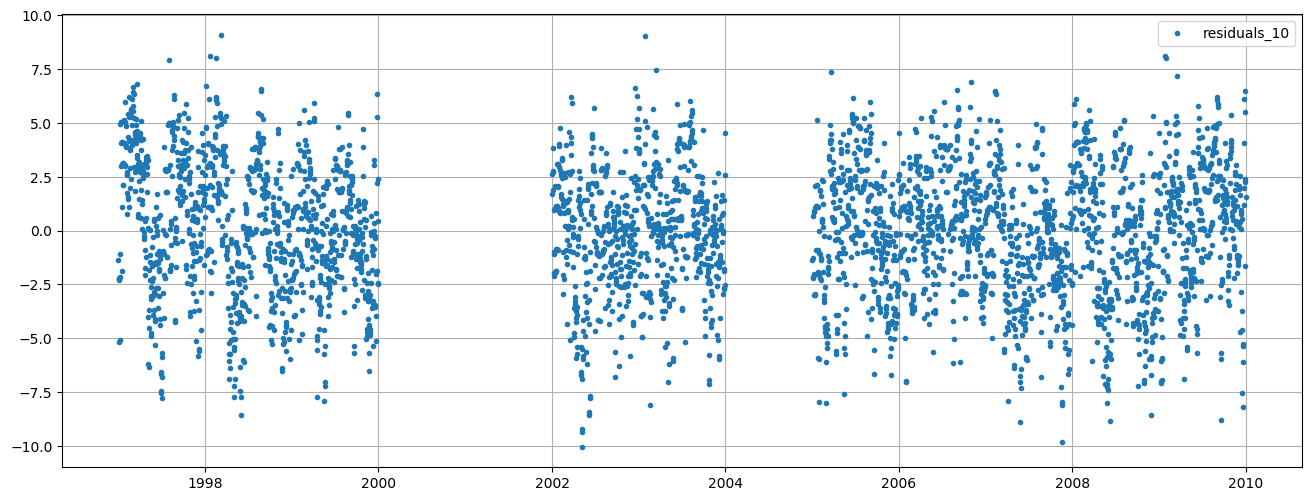

In [371]:
plot_series(seasModelResiduals_train[1],None,'.')

First-order model clearly captures the vast majority of the seasonality. Seasonal tendencies are not immediately obvious in the first-order residuals. However, short-term correlations between residuals are very evident; we see that the most extreme residuals tend to cluster together.

Let's make a table of the coefficients from fit:

In [372]:
seasonal_coefs = pd.DataFrame(index=['seasModel_%02d'%modelOrder for modelOrder in range(1,maxFreq)],
                                 columns = [el for f in range(1,11) for el in ('sin_%02d'%f,'cos_%02d'%f)])
for modelOrder in range(1,maxFreq):
    dex = 'seasModel_%02d'%modelOrder
    for f in range(1,1+modelOrder):
        seasonal_coefs.at[dex,'sin_%02d'%f] = seasModelResults[modelOrder].params['sin_%02d'%f]
        seasonal_coefs.at[dex,'cos_%02d'%f] = seasModelResults[modelOrder].params['cos_%02d'%f]

In [373]:
seasonal_coefs

,sin_01,cos_01,sin_02,cos_02,sin_03,cos_03,sin_04,cos_04,sin_05,cos_05,sin_06,cos_06,sin_07,cos_07,sin_08,cos_08,sin_09,cos_09,sin_10,cos_10
seasModel_01,-3.05091,-9.17976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seasModel_02,-3.05091,-9.17976,1.56412,0.063921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seasModel_03,-3.05091,-9.17976,1.56412,0.063921,-0.128853,-0.345789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seasModel_04,-3.05091,-9.17976,1.56412,0.063921,-0.128853,-0.345789,0.019309,0.0491848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seasModel_05,-3.05091,-9.17976,1.56412,0.063921,-0.128853,-0.345789,0.019309,0.0491848,0.182927,0.252664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seasModel_06,-3.05091,-9.17976,1.56412,0.063921,-0.128853,-0.345789,0.019309,0.0491848,0.182927,0.252664,0.0302072,0.240892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seasModel_07,-3.05091,-9.17976,1.56412,0.063921,-0.128853,-0.345789,0.019309,0.0491848,0.182927,0.252664,0.0302072,0.240892,0.0196838,-0.12133,NaN,NaN,NaN,NaN,NaN,NaN
seasModel_08,-3.05091,-9.17976,1.56412,0.063921,-0.128853,-0.345789,0.019309,0.0491848,0.182927,0.252664,0.0302072,0.240892,0.0196838,-0.12133,-0.254593,-0.14743,NaN,NaN,NaN,NaN
seasModel_09,-3.05091,-9.17976,1.56412,0.063921,-0.128853,-0.345789,0.019309,0.0491848,0.182927,0.252664,0.0302072,0.240892,0.0196838,-0.12133,-0.254593,-0.14743,-0.00733246,0.308083,NaN,NaN
seasModel_10,-3.05091,-9.17976,1.56412,0.063921,-0.128853,-0.345789,0.019309,0.0491848,0.182927,0.252664,0.0302072,0.240892,0.0196838,-0.12133,-0.254593,-0.14743,-0.00733246,0.308083,-0.0358865,-0.0360094


One nice property of the Fourier series representation: due to orthogonality of the sinusoidal basis functions, the low-order regression coefficients will not change as one adds more terms! 

We can see that the coefficients decrease at higher orders. It is likely that the high-order terms are fitting noise rather than signal.

Let's compare to the validation dataset:

In [374]:
seasModelPredictions_val = [None]
for modelOrder in range(1,1+maxFreq): 
    thisPred = ybar
    for f in range(1,1+modelOrder):
        thisPred += seasModelResults[modelOrder].params['sin_%02d'%f]*val_df['sin_%02d'%f]
        thisPred += seasModelResults[modelOrder].params['cos_%02d'%f]*val_df['cos_%02d'%f]
    seasModelPredictions_val.append(thisPred.rename('seasModel_%02d'%modelOrder))
seasModelResiduals_val=[None]
for modelOrder in range(1,1+maxFreq):
    seasModelResiduals_val.append(
        (val_df.temperature - seasModelPredictions_val[modelOrder]).rename('residuals_%02d'%freq))

In [383]:
for modelOrder in range(1,1+maxFreq):
    print('Training RMSE: model order %02d: %0.4f' % (modelOrder,seasModelResiduals_train[modelOrder].std()))
print()
for modelOrder in range(1,1+maxFreq):
    print('Validation RMSE: model order %02d: %.4f' % (modelOrder,seasModelResiduals_val[modelOrder].std()))

Training RMSE: model order 01: 3.0044
Training RMSE: model order 02: 2.7930
Training RMSE: model order 03: 2.7808
Training RMSE: model order 04: 2.7805
Training RMSE: model order 05: 2.7718
Training RMSE: model order 06: 2.7664
Training RMSE: model order 07: 2.7651
Training RMSE: model order 08: 2.7572
Training RMSE: model order 09: 2.7486
Training RMSE: model order 10: 2.7484

Validation RMSE: model order 01: 3.0362
Validation RMSE: model order 02: 2.9118
Validation RMSE: model order 03: 2.9211
Validation RMSE: model order 04: 2.9190
Validation RMSE: model order 05: 2.9098
Validation RMSE: model order 06: 2.9138
Validation RMSE: model order 07: 2.9167
Validation RMSE: model order 08: 2.9406
Validation RMSE: model order 09: 2.9744
Validation RMSE: model order 10: 2.9730


Training loss keeps decreasing as more terms are added, but validation loss climbs at high model orders. Minimum val loss occurs at order 5, but this is just barely lower than the next-lowest loss at order 2. 

In [389]:
losses = pd.DataFrame({'training_loss':[seasModelResiduals_train[MO].std() for MO in rangeMO] \
              ,'val_loss':[seasModelResiduals_val[MO].std() for MO in rangeMO]},index=rangeMO)

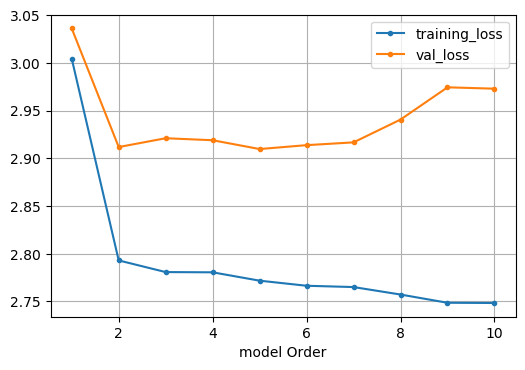

In [398]:
plot_series(losses,['training_loss','val_loss'],'.-',figsize=(6,4),xlabel='model Order')

We'll go with seasonality model order 2.

In [ ]:
plt.plot(dfFull.DOY,residuals_01,'.')
plt.plot([0,1],[0,0],'k-')

In [ ]:
allfreqs = range(1,11)
pd.Series([residuals[f].std() for f in allfreqs],index=allfreqs)

In [ ]:
print(dfFull.temperature.std())

In [ ]:
timeRange = (dfFull.date.dt.year<2002)
for f in allfreqs:
    plt.plot(dfFull.date[timeRange],dfFull.temperature[timeRange])
    plt.plot(dfFull.date[timeRange],preds[f][timeRange],color=[1,0,0],linewidth=3)
    plt.title('Seasonal Model %02d' % f)
    plt.show()

In [ ]:
train = dfFull[dfFull.date.dt.year<2010]
val   = dfFull[dfFull.date.dt.year>=2010]

In [ ]:
# Fit 10 models, up to maxFreq=10
sm_seasModel = [None]
fittedModels = [None]
for freq in range(1,1+maxFreq): 
    components_TL = [(('sin_%02d'%f),('cos_%02d'%f)) for f in range(1,1+freq)]
    components = [component for pair in components_TL for component in pair]
    sm_seasModel.append(OLS(train.temperature,sm.add_constant(train[components]),missing='drop'))
    fittedModels.append(sm_seasModel[-1].fit())

In [ ]:
preds = [None]
for freq in range(1,1+maxFreq): 
    thisPred = fittedModels[freq].params.const
    for f in range(1,1+freq):
        thisPred += fittedModels[freq].params['sin_%02d'%f]*train['sin_%02d'%f]
        thisPred += fittedModels[freq].params['cos_%02d'%f]*train['cos_%02d'%f]
    preds.append(thisPred.rename('seasModel_%02d'%freq))
residuals=[None]
for freq in range(1,1+maxFreq):
    residuals.append((train.temperature - preds[freq]).rename('residuals_%02d'%freq))

In [ ]:
allfreqs = range(1,11)
pd.Series([residuals[f].std() for f in allfreqs],index=allfreqs)
# Training Set RMSE:

In [ ]:
valPredictions = [None]
for freq in range(1,1+maxFreq): 
    thisPred = fittedModels[freq].params.const
    for f in range(1,1+freq):
        thisPred += fittedModels[freq].params['sin_%02d'%f]*val['sin_%02d'%f]
        thisPred += fittedModels[freq].params['cos_%02d'%f]*val['cos_%02d'%f]
    valPredictions.append(thisPred.rename('seasModel_%02d'%freq))
valResiduals=[None]
for freq in range(1,1+maxFreq):
    valResiduals.append((val.temperature - valPredictions[freq]).rename('residuals_%02d'%freq))

In [ ]:
allfreqs = range(1,11)
pd.Series([valResiduals[f].std() for f in allfreqs],index=allfreqs)
# Validation Set RMSE:

Validation performance suggests that we're overfitting at model 03 and beyond.

Therefore, we will choose model 02 for our seasonal variation.

# Auto-Regressive Model

We have lowered RMSE to 3 with the seasonality model. Variation above and beyond the seasonality should be auto-regressive, so we can improve our prediction by adding the most recent daily measurements to the model.

Exploration earlier suggests that this auto-regression is very unlikely to require more than three days recent measurements.

Try to predict the residuals (after seasonality) using linear models AR(1), AR(2), and AR(3) 

In [ ]:
residuals[2]

In [ ]:
cleanSelection = pd.Series(residuals[2].index>pd.Timestamp('2004-02-01'),index=residuals[2].index)

In [ ]:
pd.Series(residuals[2].index>pd.Timestamp('2004-02-01'),index=residuals[2].index)

In [ ]:
tsplot(residuals[2][cleanSelection], lags=5)

### This is Strong Evidence for AR(1) being sufficient

In [ ]:
def tsXYScatter(timeseries,lag):
    X=timeseries[:(-lag or None)]
    Y=timeseries[lag:]
    plt.scatter(X,Y)
    plt.title('Scatterplot: Lag = %d' % lag)

In [ ]:
tsXYScatter(residuals[2][cleanSelection],lag=1)

AR(1) is just another OLS linear model with a single predictor. 

In [ ]:
X = residuals[2][cleanSelection].iloc[:-1]
y = residuals[2][cleanSelection].iloc[1:]

In [ ]:
y

In [ ]:
AR1 = OLS(pd.Series(list(y),index=X.index),sm.add_constant(pd.DataFrame(X)),missing='drop')
ar1_results = AR1.fit()

In [ ]:
ar1_results.params

In [ ]:
final_predictions_train = X*ar1_results.params.residuals_02 + ar1_results.params.const
final_residuals_train = y-final_predictions_train

In [ ]:
final_residuals_train.std()

In [ ]:
final_residuals_train.abs().mean()

In [ ]:
# Better than expected

In [ ]:
final_predictions_val = pd.Series(list(valResiduals[2].iloc[:-1])) *ar1_results.params.residuals_02 + ar1_results.params.const
final_residuals_val = pd.Series(list(valResiduals[2].iloc[1:]))-final_predictions_val

In [ ]:
final_predictions_val

In [ ]:
valResiduals[2].iloc[1:]

In [ ]:
final_predictions_val

In [ ]:
final_residuals_val

In [ ]:
final_residuals_val.abs().mean()

# Apply to Test Set:

In [ ]:
test_df

In [ ]:
for freq in [1,2]:
    test_df['sin_%02d'%freq] = np.sin(2*np.pi*test_df.DOY*freq)
    test_df['cos_%02d'%freq] = np.cos(2*np.pi*test_df.DOY*freq)

In [ ]:
test_df.head()

In [ ]:
test_seasonality = fittedModels[2].params.const \
                    + fittedModels[2].params.sin_01*test_df.sin_01 \
                    + fittedModels[2].params.cos_01*test_df.cos_01 \
                    + fittedModels[2].params.sin_02*test_df.sin_02 \
                    + fittedModels[2].params.cos_02*test_df.cos_02

In [ ]:

testPredictions = test_seasonality[1:] \
                    + ar1_results.params.residuals_02 * \
                    (pd.Series(list(test_df.temperature.iloc[:-1]),index=test_df.index[1:])-test_seasonality[1:]) \
                    + ar1_results.params.const

In [ ]:
testPredictions

In [ ]:
testResiduals = (test_df.temperature.iloc[1:] - testPredictions)

In [ ]:
testResiduals.std()

In [ ]:
# Test MAE:

In [ ]:
testResiduals.abs().mean()

# Extra Stuff

In [ ]:
# Can run Ljung-Box test to determine independence of final residuals:

In [ ]:
[smQ,smP] = sm_acorr_ljungbox(residuals[2][cleanSelection],lags=30)

In [ ]:
[smQ,smP]

# Missing Data

In [ ]:
# Possibly a helpful library from R

https://cran.r-project.org/web/packages/imputeTS/imputeTS.pdf